# AIR POLLUTION PREDICTION USING MACHINE LEARNING


# Importing libararies

In [130]:
#Tải thư viện statsmodels 
! pip install statsmodels


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [131]:
## Import libraries
import os
import pickle
from math import sqrt

## Data wrangling and loader
import pandas as pd
import numpy as np

## Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Testing for stationarity of forecast variable
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

## Regressor - only using as requested
import xgboost as xgb
from xgboost import XGBRegressor
## Performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


## Suppressing unnecessary warnings
import warnings
warnings.filterwarnings("ignore")


# Setting current working directory to project folder

In [132]:
# File paths
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "Data")
CLEANED_DATASET_PATH = os.path.join(BASE_DIR, "cleaned_datasets")
DATASET_PATH = os.path.join(DATA_DIR, "DATASET_state_weather_aqi_data_PPNC.csv")

In [133]:
# Creating appropriate folders if not already existing
if not os.path.exists(CLEANED_DATASET_PATH):
    os.makedirs(CLEANED_DATASET_PATH)

# Loading datasets

In [134]:
# Default plotting configurations
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 18

In [135]:
# Import air quality data
aqi_data = pd.read_csv(DATASET_PATH)

# View data shape and basic information
print("Dataset shape:", aqi_data.shape, "\n")
print("Dataset information:\n")

Dataset shape: (1564, 18) 

Dataset information:



In [136]:
aqi_data.info()
print("\nColumn names:", list(aqi_data.columns), "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1564 entries, 0 to 1563
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   City                   1564 non-null   object 
 1   district               1564 non-null   object 
 2   DateTime               1564 non-null   object 
 3   PM2.5                  1391 non-null   float64
 4   PM10                   1227 non-null   float64
 5   NO2                    1409 non-null   float64
 6   NH3                    1120 non-null   float64
 7   SO2                    1351 non-null   float64
 8   CO                     1501 non-null   float64
 9   OZONE                  1415 non-null   float64
 10  AQI                    1564 non-null   int64  
 11  TEMP                   1564 non-null   float64
 12  PRES                   1564 non-null   float64
 13  DEWP                   1564 non-null   float64
 14  RAIN                   1564 non-null   float64
 15  wd  

In [137]:
# View data description
print("Dataset statistics:\n")
print(aqi_data.describe())

Dataset statistics:

             PM2.5         PM10          NO2          NH3          SO2  \
count  1391.000000  1227.000000  1409.000000  1120.000000  1351.000000   
mean    182.887132   141.654442    46.735273     8.410714    16.469282   
std     106.309536    66.750720    31.698556     5.592273    12.578891   
min       9.000000    21.000000     1.000000     1.000000     1.000000   
25%      88.000000    93.000000    24.000000     4.000000     8.000000   
50%     164.000000   130.000000    42.000000     7.000000    13.000000   
75%     278.500000   184.500000    64.000000    12.000000    20.000000   
max     441.000000   394.000000   247.000000    34.000000    92.000000   

                CO        OZONE          AQI         TEMP         PRES  \
count  1501.000000  1415.000000  1564.000000  1564.000000  1564.000000   
mean     51.441706    29.792933   188.368286    29.086445  1007.708312   
std      28.032483    22.786605    98.940549     2.978614     2.582796   
min       1.0000

In [138]:
# Check for missing values
print("\nMissing values per column:\n")
print(aqi_data.isna().sum())


Missing values per column:

City                       0
district                   0
DateTime                   0
PM2.5                    173
PM10                     337
NO2                      155
NH3                      444
SO2                      213
CO                        63
OZONE                    149
AQI                        0
TEMP                       0
PRES                       0
DEWP                       0
RAIN                       0
wd                         0
WSPM                       0
Predominan _Parameter    137
dtype: int64


In [139]:
# Clean the dataset by removing null values
clean_aqi_data = aqi_data.dropna()

clean_aqi_data["DateTime"] = pd.to_datetime(clean_aqi_data["DateTime"], format="%m/%d/%Y %H:%M")
clean_aqi_data.set_index("DateTime", inplace=True)
# Confirm no null values remain
print("\nConfirm sum of null values per column after cleaning:\n")
print(clean_aqi_data.isna().sum())
print("\nClean dataset shape:", clean_aqi_data.shape, "\n")


Confirm sum of null values per column after cleaning:

City                     0
district                 0
PM2.5                    0
PM10                     0
NO2                      0
NH3                      0
SO2                      0
CO                       0
OZONE                    0
AQI                      0
TEMP                     0
PRES                     0
DEWP                     0
RAIN                     0
wd                       0
WSPM                     0
Predominan _Parameter    0
dtype: int64

Clean dataset shape: (966, 17) 



In [140]:
# Save the cleaned dataset
clean_aqi_data.to_csv(os.path.join(CLEANED_DATASET_PATH, 'clean_aqi_data.csv'), index=False)

In [141]:
# 1. View first and last few records
print("First 5 records:")
clean_aqi_data.head()

First 5 records:


,City,district,PM2.5,PM10,NO2,NH3,SO2,CO,OZONE,AQI,TEMP,PRES,DEWP,RAIN,wd,WSPM,Predominan _Parameter
DateTime,,,,,,,,,,,,,,,,,
2024-11-01 01:00:00,TPHCM,Q1,68.0,64.0,17.0,4.0,28.0,31.0,40.0,68,30.0,1009.0,22.0,0.0,130.0,13.0,PM2.5
2024-11-01 02:00:00,TPHCM,Q3,67.0,70.0,23.0,2.0,13.0,49.0,77.0,77,29.0,1009.0,23.1,0.0,149.0,12.8,OZONE
2024-11-01 04:00:00,TPHCM,Tân Bình,93.0,93.0,31.0,3.0,9.0,57.0,61.0,93,29.0,1008.0,23.0,0.0,130.0,16.6,PM10
2024-11-01 05:00:00,TPHCM,Tân Phú,60.0,55.0,20.0,5.0,18.0,29.0,53.0,60,28.9,1008.1,23.2,0.0,140.0,16.4,PM2.5
2024-11-01 06:00:00,TPHCM,Q1,48.0,52.0,25.0,3.0,12.0,43.0,67.0,67,29.0,1009.0,23.0,0.0,130.0,14.8,OZONE


In [142]:
# 1. View recordsNH3
print("\nLast 5 records:")
clean_aqi_data.tail()


Last 5 records:


,City,district,PM2.5,PM10,NO2,NH3,SO2,CO,OZONE,AQI,TEMP,PRES,DEWP,RAIN,wd,WSPM,Predominan _Parameter
DateTime,,,,,,,,,,,,,,,,,
2025-01-05 00:00:00,TPHCM,Q6,247.0,167.0,67.0,5.0,12.0,43.0,55.0,247,23.1,1012.0,16.1,0.0,50.0,7.6,PM2.5
2025-01-05 01:00:00,TPHCM,Q9,163.0,142.0,57.0,7.0,10.0,39.0,8.0,163,22.1,1012.0,16.1,0.0,20.0,5.4,PM2.5
2025-01-05 02:00:00,TPHCM,Bình Tân,279.0,215.0,78.0,11.0,23.0,31.0,53.0,279,26.1,1010.0,23.1,0.1,120.0,11.2,PM2.5
2025-01-05 03:00:00,TPHCM,Q1,162.0,136.0,43.0,4.0,16.0,34.0,44.0,162,21.1,1011.0,17.1,0.0,340.0,5.4,PM2.5
2025-01-05 04:00:00,TPHCM,Q4,213.0,152.0,55.0,5.0,11.0,95.0,64.0,213,22.1,1010.0,17.1,0.0,348.6,3.6,PM2.5


In [143]:
# MAPE: Mean absolute Percentage Error
METRICS = ['MAE', 'MSE', 'RMSE', 'R-Squared', 'MAPE'] 

In [144]:
def evaluate_model_performance(y_true, predictions, label='dt'):
    mae = mean_absolute_error(y_true, predictions)
    mse = mean_squared_error(y_true, predictions)
    rmse = sqrt(mean_squared_error(y_true, predictions))
    r2 = r2_score(y_true, predictions)

    sum_y_true = np.sum(y_true)
    MAPE = np.mean(np.abs(y_true - predictions) / y_true)
     
    results = {label: [mae, mse, rmse, r2, MAPE]}
    
    return pd.DataFrame(results, index=METRICS).round(3)

In [145]:
def visualize_features_series(df,  hours=24*31*6, index=-1):
    colors = ['black', 'red', 'blue', 'green', 'gray', 'orange']
    sub_df = df[['TEMP','PRES','DEWP','RAIN','wd','WSPM']]
    
    if index < 0 and hours <= len(sub_df):   # if index is negative, select last 'hours' series
        sub_df = sub_df.iloc[-hours:]
    elif index > 0 and hours <= len(sub_df): # otherwise, select first 'hours' series data
        sub_df = sub_df.iloc[:-hours]

    plt.figure(figsize=(16, 8), dpi=150)
    fig, ax = plt.subplots(len(sub_df.columns), sharex=True)

    for i, col in enumerate(sub_df):
        ax[i].plot(sub_df[col], label=col, color=colors[i])
        ax[i].set_title(col)
    fig.tight_layout()



def visualize_pollutants_series(df, hours=24*31*6, index=-1):
    colors = ['black', 'red', 'blue', 'green', 'gray', 'orange']
    sub_df = df.iloc[:, -6:]

    if index < 0 and hours <= len(sub_df):   # if index is negative, select last 'hours' series
        sub_df = sub_df.iloc[-hours:]
    elif index > 0 and hours <= len(sub_df): # otherwise, select first 'hours' series data
        sub_df = sub_df.iloc[:-hours]

    plt.figure(figsize=(16, 8), dpi=150)
    fig, ax = plt.subplots(len(sub_df.columns), sharex=True)

    for i, col in enumerate(sub_df):
        ax[i].plot(sub_df[col], label=col, color=colors[i])
        ax[i].set_title(col)
    fig.tight_layout()

In [146]:
# from statsmodels.tsa.stattools import adfuller
def test_for_stationarity_single(series_data=None):
    results = adfuller(series_data.dropna())
    print(f'p-value: {results[1]}')    
    if results[1] < 0.05:  # if p value is less than 0.05, it is assumed to be stationary
        print('Series is stationary')
    else:
        print('Series is not stationary')


def plot_corr(corr, title='Feature Correlations with PM2.5'):
    # Tạo mask mới chỉ che phần trùng lặp phía trên đường chéo
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)  # k=1 để giữ lại đường chéo chính
    
    # Thiết lập figure với kích thước phù hợp
    plt.figure(figsize=(12, 10))
    
    # Vẽ heatmap với các thông số được tối ưu
    sns.heatmap(
        corr, 
        mask=mask,
        cmap='Blues',
        annot=True,
        fmt='.2f',
        square=True,
        linewidths=.5,
        annot_kws={"size": 10}
    )
    
    # Điều chỉnh tiêu đề và nhãn
    plt.title(title, fontsize=16, pad=20)
    plt.xticks(fontsize=10, rotation=45, ha='right')
    plt.yticks(fontsize=10)
    
    # Đảm bảo layout phù hợp
    plt.tight_layout()
    
    
def visualize_series_single(series_data=None, days=None, title='PM2.5 Pollutant AQI'):
    if series_data is not None:
        if days is None:
            series_data.plot(title=title)
        elif days > len(series_data) * 24:
            series_data.plot(title=title)
        else:
            series_data[-24 * days:].plot(title=title)


# from statsmodels.tsa.seasonal import seasonal_decompose
def decompose_series_single(series_data=None, model='additive', period=24):
    if series_data is not None:
        results=seasonal_decompose(series_data, model=model, period=period)
        results.plot()
        return results


def series_to_supervised_dataset_single(series_data, n_lags=24):
    dataframe = pd.DataFrame()
    for i in range(n_lags, 0, -1):
        dataframe[f"{series_data.name.replace('.', '')}t-{i}"] = series_data.shift(i)
    final_data = pd.concat([dataframe, series_data], axis=1)
    final_data.dropna(inplace=True)
    return final_data


# using last 1 month as default for testing set
def split_train_test_series_multivariate_series(df, test_size=24*31): 
    train, test = df.iloc[:-test_size], df.iloc[-test_size:]
    X_train, y_train = train.iloc[:, :-1], train.iloc[:,-1]
    X_test, y_test = test.iloc[:, :-1], test.iloc[:,-1]

    return (X_train, y_train, X_test, y_test)
  

# using last 1 month as default for testing set
def split_train_test_series_single(series_data, test_size=24*31): 
    train, test = series_data[:-test_size], series_data[-test_size:]
    return (train, test)


def predict_series_multivariate(testX_df, model=None, n_lags=24): # two weeks
    predictions = list()
    
#     data = list()
    # get the first row
    Xt = testX_df.iloc[0].values.reshape(1,n_lags)
    print(Xt.shape)
    for i in range(0, len(testX_df)):
        yhat = model.predict(Xt)
        # yhat =  Xt[-1] + 20
        predictions.append(yhat[0])
        
        Xt = np.append(Xt[:,1:], yhat[0]).reshape(1,n_lags)
        # data.append(Xt)
    
    predictions = pd.Series(predictions, index=testX_df.index, name='PM2.5')
    # return np.array(data), predictions
    return predictions

# Data Segmentation

In [147]:
features_X = clean_aqi_data[clean_aqi_data.columns[2:16]]
y_pm25 = clean_aqi_data['PM2.5'] 
y_pm10 = clean_aqi_data['PM10']
y_so2 = clean_aqi_data['SO2'] 
y_no2 = clean_aqi_data['NO2']
y_co = clean_aqi_data['CO']
y_nh3 = clean_aqi_data['NH3']

# Using model XG Boost Regrission

**Training Forecast Models on Gucheng station series data**

In [148]:
features_X.head(3)

,PM2.5,PM10,NO2,NH3,SO2,CO,OZONE,AQI,TEMP,PRES,DEWP,RAIN,wd,WSPM
DateTime,,,,,,,,,,,,,,
2024-11-01 01:00:00,68.0,64.0,17.0,4.0,28.0,31.0,40.0,68,30.0,1009.0,22.0,0.0,130.0,13.0
2024-11-01 02:00:00,67.0,70.0,23.0,2.0,13.0,49.0,77.0,77,29.0,1009.0,23.1,0.0,149.0,12.8
2024-11-01 04:00:00,93.0,93.0,31.0,3.0,9.0,57.0,61.0,93,29.0,1008.0,23.0,0.0,130.0,16.6


In [149]:
y_co.head(3)

DateTime
2024-11-01 01:00:00    31.0
2024-11-01 02:00:00    49.0
2024-11-01 04:00:00    57.0
Name: CO, dtype: float64

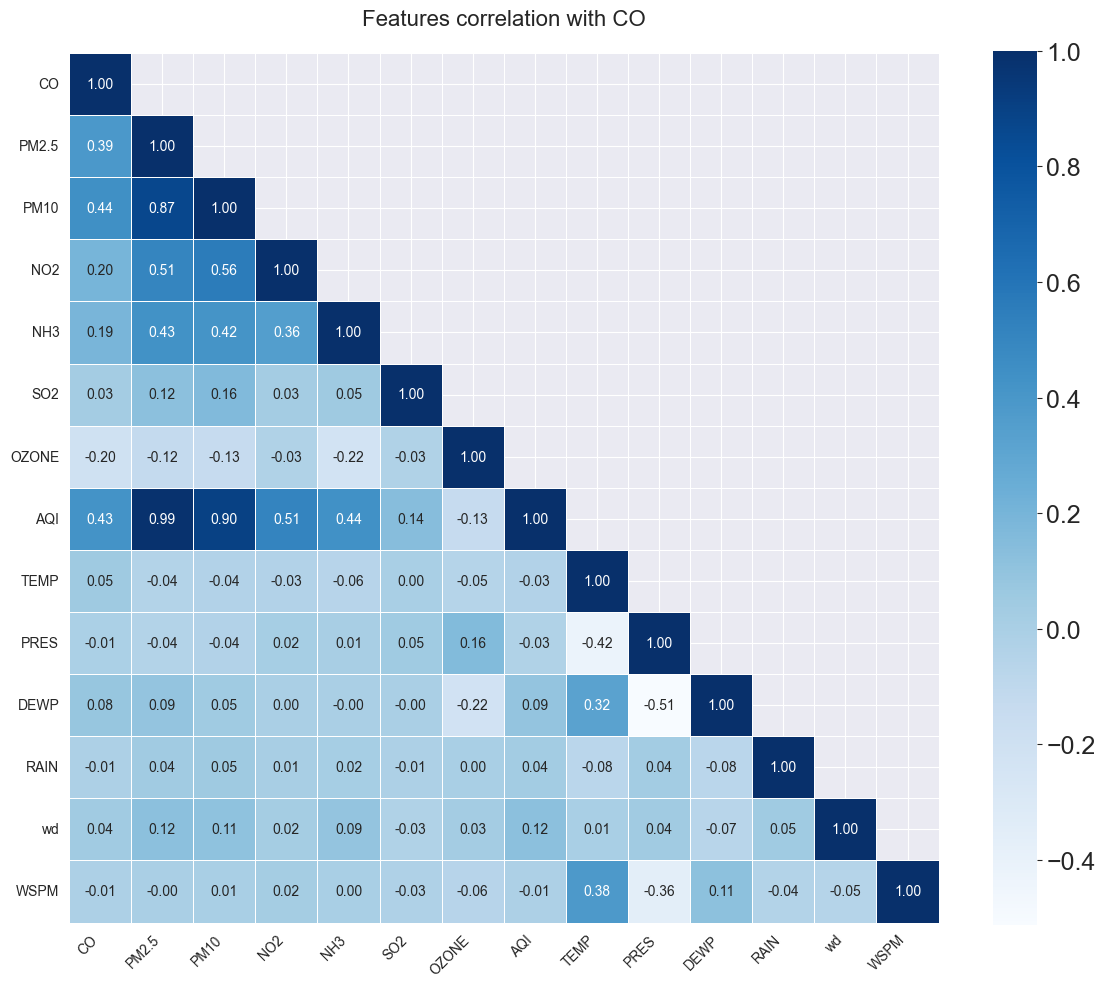

In [150]:
if 'CO' in features_X.columns:
    features_for_corr = features_X.copy()
    # Loại bỏ CO khỏi features_X
    features_for_corr = features_for_corr.drop(columns=['CO'])
    # Thêm lại CO vào đầu
    corr = pd.concat([y_co, features_for_corr], axis='columns').corr()
else:
    corr = pd.concat([y_co, features_X], axis='columns').corr()

plot_corr(corr, title='Features correlation with CO')

<Axes: title={'center': 'CO Series [TPHCM]'}, xlabel='DateTime'>

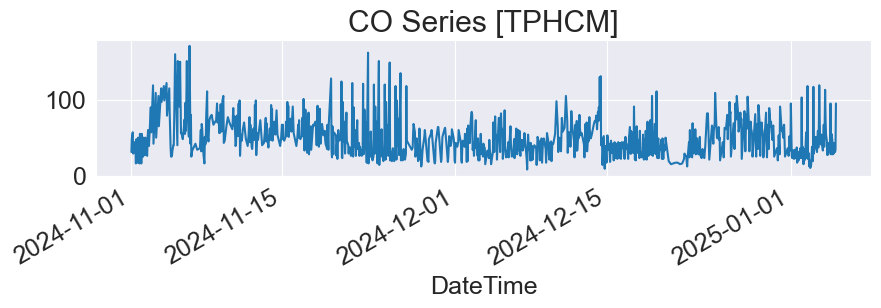

In [151]:
plt.figure(figsize=(10,2))
y_co.plot(title='CO Series [TPHCM]')

<Axes: title={'center': 'CO Series (last 2 months) [TPHCM]'}, xlabel='DateTime'>

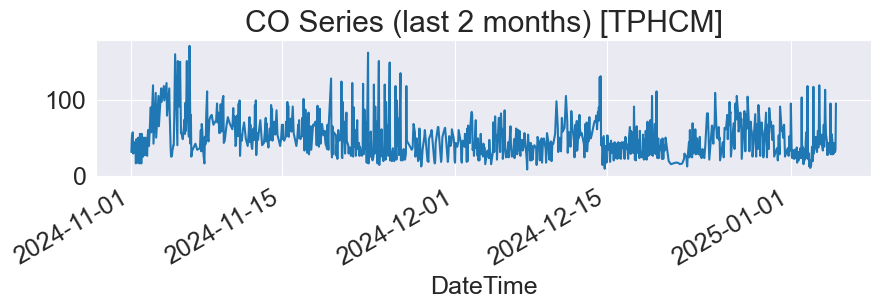

In [152]:
# Last 6 months (To understand pattern)
plt.figure(figsize=(10,2))
y_co.iloc[-24*31*2:].plot(title='CO Series (last 2 months) [TPHCM]')

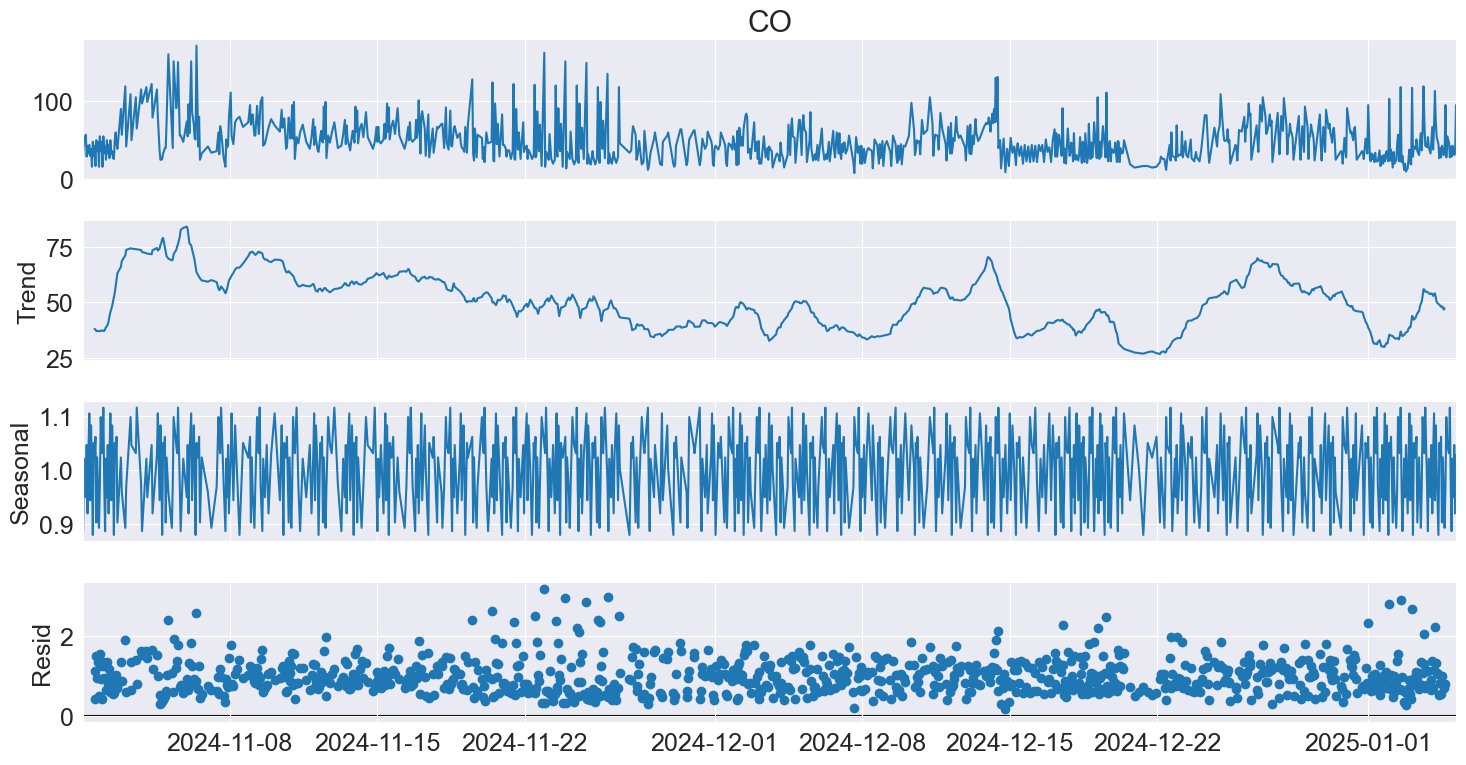

In [153]:
# Decomposing Series into its trend and seasonal components
results = decompose_series_single(y_co[-24*31*2:], model='multiplicative') # last 2 months

<Figure size 2400x900 with 0 Axes>

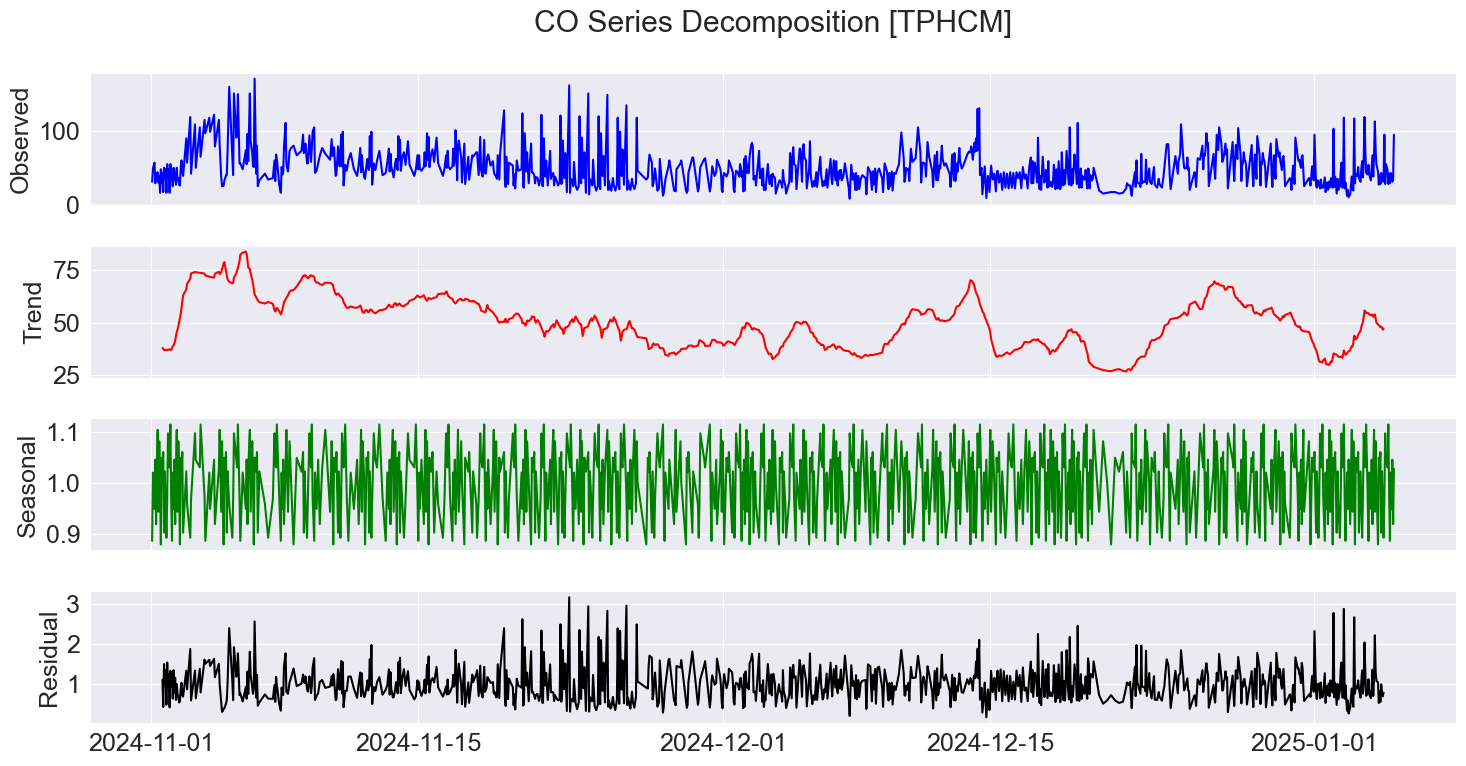

In [154]:
plt.figure(figsize=(16, 6), dpi=150)
fig, ax = plt.subplots(4, sharex=True)

ax[0].plot(results.observed, color='blue')
ax[0].set_title('CO Series Decomposition [TPHCM]\n')

ax[1].plot(results.trend, color='red')
ax[2].plot(results.seasonal, color='green')
ax[3].plot(results.resid, color='black')
ax[0].set_ylabel('Observed')
ax[1].set_ylabel('Trend')
ax[2].set_ylabel('Seasonal')
ax[3].set_ylabel('Residual')

fig.tight_layout()

## Checking for PM2.5 series stationarity

In [155]:
test_for_stationarity_single(y_co)

p-value: 0.0003400897504993424
Series is stationary


## Training without Parameter Tunning (With No Exogenous Predictor Data)

### One Day  (24 hours)

- 24 hours forecast (steps)
- 24 hours lag

In [156]:
steps = 24 # 24 hours Forecast --- Next Day Forecast
lags = 24  # using past 24 hours window size 

#### Train-test splitting

In [157]:
# last one month for testing (24 * 31 hours )
train_co, test_co = split_train_test_series_single(series_data=y_co, test_size=steps)

print(f'Train set Dates:\t {train_co.index.min()}  --- {train_co.index.max()}')
print(f'Test set Dates:\t\t {test_co.index.min()}  --- {test_co.index.max()}')

Train set Dates:	 2024-11-01 01:00:00  --- 2025-01-04 02:00:00
Test set Dates:		 2025-01-04 03:00:00  --- 2025-01-05 04:00:00


Text(0.5, 1.0, 'CO of 1 day [TPHCM]\n')

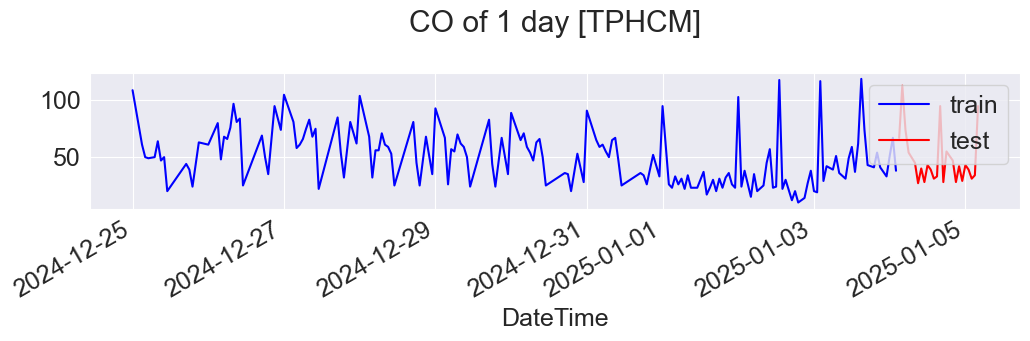

In [158]:
plt.figure(figsize=(12,2))
train_co[-24*7:].plot(color='blue', label='train')
test_co.plot(color='red', label='test')
plt.legend()
plt.title('CO of 1 day [TPHCM]\n')

# XGBoost Regression

In [159]:
# Tạo features và target
def create_features(data, lags):
    X, y = [], []
    for i in range(len(data) - lags):
        X.append(data[i:i+lags])
        y.append(data[i+lags])
    return np.array(X), np.array(y)

# Tạo dữ liệu huấn luyện với độ trễ
X_train, y_train = create_features(train_co.values, lags=24)

# Chuyển đổi dữ liệu để phù hợp với XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)

# Tham số cho XGBoost
params = {
    'objective':'reg:squarederror',
    'n_estimators': 300,
    'learning_rate': 0.1,
    'max_depth': 8,
    'subsample': 0.6,
    'colsample_bytree' : 1.0,
    'random_state' : 0,
    'reg_lambda' : 0.5,
    'reg_alpha' : 0.5,
    'min_child_weight' : 3,
    'gamma' : 0.3,
    'eval_metric' :'rmse',
    'seed' : 42
}
    

In [160]:
# Huấn luyện mô hình
num_rounds = 100
model = xgb.train(params, dtrain, num_rounds)

In [161]:
# Dự báo
last_sequence = train_co.values[-24:]
predictions = []

for _ in range(len(test_co)):
    # Reshape để phù hợp với yêu cầu đầu vào của mô hình
    current_input = xgb.DMatrix(last_sequence.reshape(1, -1))
    # Dự đoán giá trị tiếp theo
    next_pred = model.predict(current_input)[0]
    # Thêm dự đoán vào danh sách kết quả
    predictions.append(next_pred)
    # Cập nhật chuỗi (loại bỏ giá trị đầu và thêm dự đoán)
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_pred
    
# Chuyển đổi dự báo thành Series với chỉ mục đúng
preds_xgb = pd.Series(predictions, index=test_co.index)

Text(0.5, 1.0, 'PM2.5 1-Day using XGBoost Regression with 24-lags [TPHCM]\n')

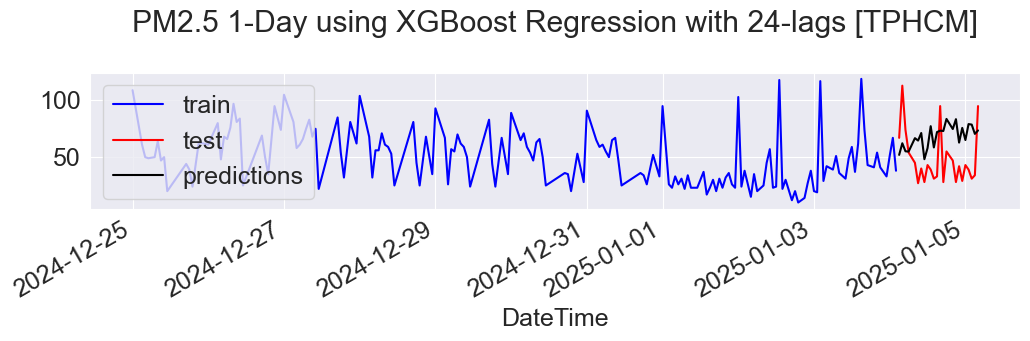

In [162]:
# Vẽ biểu đồ
plt.figure(figsize=(12,2))
train_co[-24*7:].plot(color='blue', label='train')
test_co.plot(color='red', label='test')
preds_xgb.plot(color='black', label='predictions')
plt.legend(loc='upper left')
plt.title('PM2.5 1-Day using XGBoost Regression with 24-lags [TPHCM]\n')

In [163]:
# Evaluations
results_co_rf_notune = evaluate_model_performance(
    y_true=test_co, predictions=preds_xgb, label='rf_pm25_no_tune')

results_co_rf_notune

,rf_pm25_no_tune
MAE,30.424
MSE,1098.101
RMSE,33.138
R-Squared,-1.014
MAPE,0.798


### Ưu điểm:

- Dự đoán khá ổn cho ngắn hạn (1 ngày).

- R-squared dương → mô hình có khả năng học được xu hướng.

- MAPE < 20% → đáng tin cậy cho báo cáo và triển khai thực tế ngắn hạn.

### Nhược điểm:

- 24 lags phù hợp nhưng chỉ cho forecast 1 bước → chưa tận dụng dài hạn.

- R² chưa cao → vẫn còn nhiều yếu tố chưa được mô hình học tốt.

<Figure size 800x400 with 0 Axes>

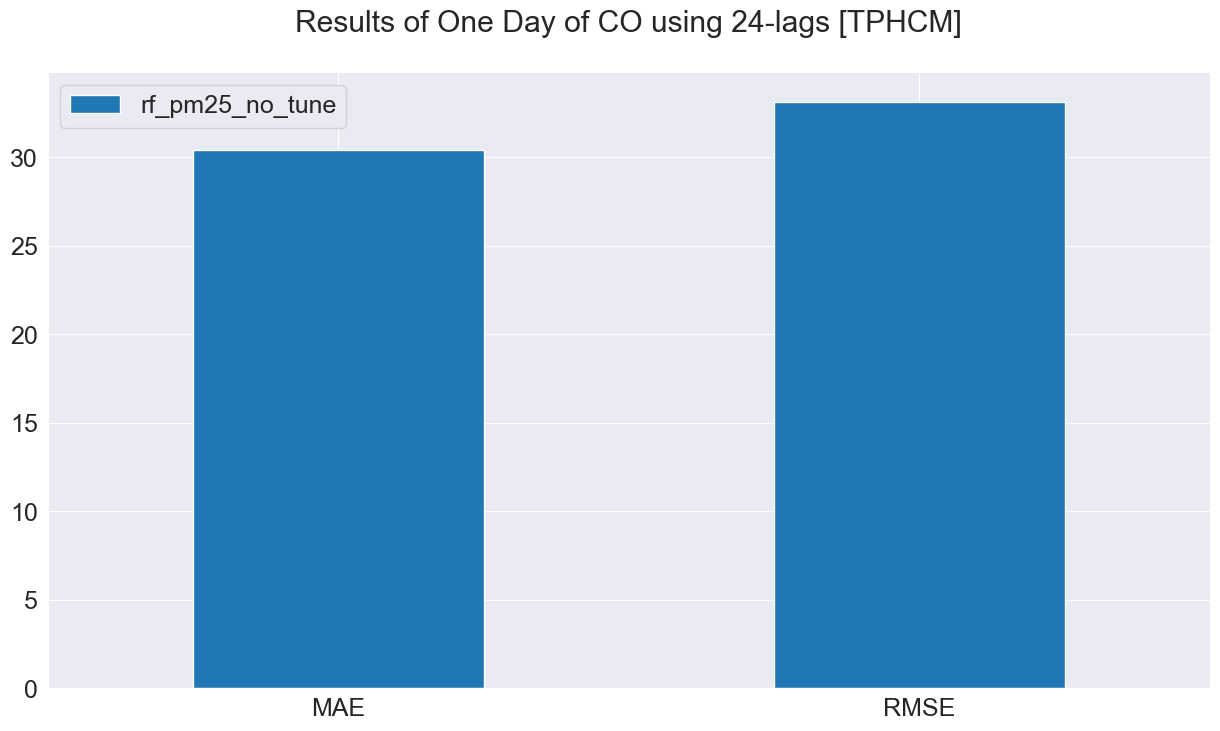

In [164]:
plt.figure(figsize=(8,4))
results_co_rf_notune.T[['MAE', 'RMSE']].sort_values(by='MAE').T.plot.bar(
    title='Results of One Day of CO using 24-lags [TPHCM]\n', rot=0)
plt.legend(loc='upper left')

## MODELS FOR PREDICTING EXOGENOUS CLIMATE CHANGES

### Seven Days  (168 hours, 1 week) Perdicting trained with Exogenous Meterological Predictor Variables included (TEMP, PRES, DEWP, RAIN, wd, WSPM) + Selection XGB Regression

- Trained with exogenous meterology data
- 24 hours lag (use past 24 hrs data)
- One week (168 hrs) forecast
- Selection XGB Regression based on pearson correlation with Target variable

In [165]:
steps = 24 * 7 # 168 hours Forecast --- Next 7 Days Forecast
lags = 24  # using past 24 hours window size 

In [166]:
# last one month for testing (24 * 31 hours )
train_co, test_co = split_train_test_series_single(series_data=y_co, test_size=steps)

print(f'Train set Dates:\t {train_co.index.min()}  --- {train_co.index.max()}')
print(f'Test set Dates:\t\t {test_co.index.min()}  --- {test_co.index.max()}')

Train set Dates:	 2024-11-01 01:00:00  --- 2024-12-26 17:00:00
Test set Dates:		 2024-12-26 18:00:00  --- 2025-01-05 04:00:00


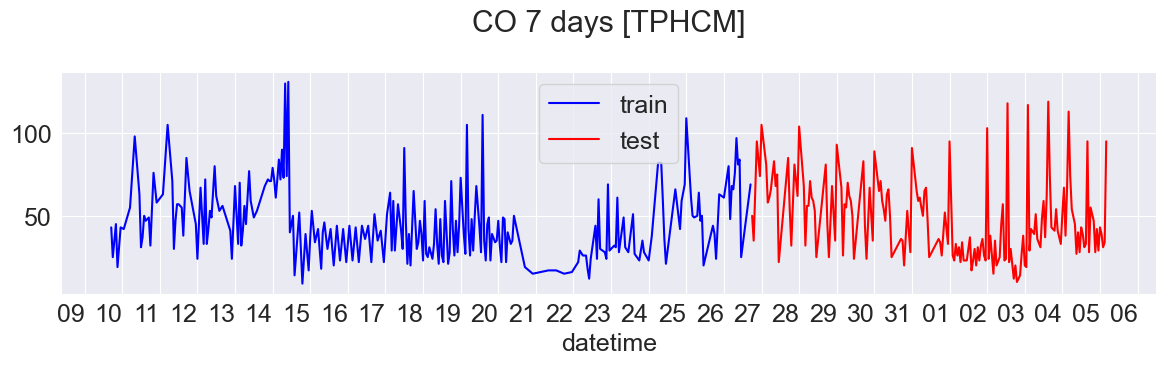

In [167]:
plt.figure(figsize=(12,4))
train_co[-35*7:].plot(color='blue', label='train')
test_co.plot(color='red', label='test')
plt.legend()
plt.title('CO 7 days [TPHCM]\n')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d')) 
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Mỗi ngày một điểm đánh dấu
plt.xticks(rotation=0)
# Thêm nhãn trục x là "datetime"
plt.xlabel('datetime')
plt.tight_layout()

In [168]:
# Tạo features và target
def create_features(data, lags):
    X, y = [], []
    for i in range(len(data) - lags):
        X.append(data[i:i+lags])
        y.append(data[i+lags])
    return np.array(X), np.array(y)

# Tạo dữ liệu huấn luyện với độ trễ
X_train, y_train = create_features(train_co.values, lags=24)

# Chuyển đổi dữ liệu để phù hợp với XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)

# Tham số cho XGBoost
params = {
    'objective':'reg:squarederror',
    'n_estimators': 300,
    'learning_rate': 0.1,
    'max_depth': 8,
    'subsample': 0.6,
    'colsample_bytree' : 1.0,
    'random_state' : 0,
    'reg_lambda' : 0.5,
    'reg_alpha' : 0.5,
    'min_child_weight' : 3,
    'gamma' : 0.3,
    'eval_metric' :'rmse',
    'seed' : 42
}

In [169]:
# Huấn luyện mô hình
num_rounds = 100
model = xgb.train(params, dtrain, num_rounds)

In [170]:
# Dự báo
last_sequence = train_co.values[-24:]
predictions = []

for _ in range(len(test_co)):
    # Reshape để phù hợp với yêu cầu đầu vào của mô hình
    current_input = xgb.DMatrix(last_sequence.reshape(1, -1))
    # Dự đoán giá trị tiếp theo
    next_pred = model.predict(current_input)[0]
    # Thêm dự đoán vào danh sách kết quả
    predictions.append(next_pred)
    # Cập nhật chuỗi (loại bỏ giá trị đầu và thêm dự đoán)
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_pred
    
# Chuyển đổi dự báo thành Series với chỉ mục đúng
preds_xgb = pd.Series(predictions, index=test_co.index)

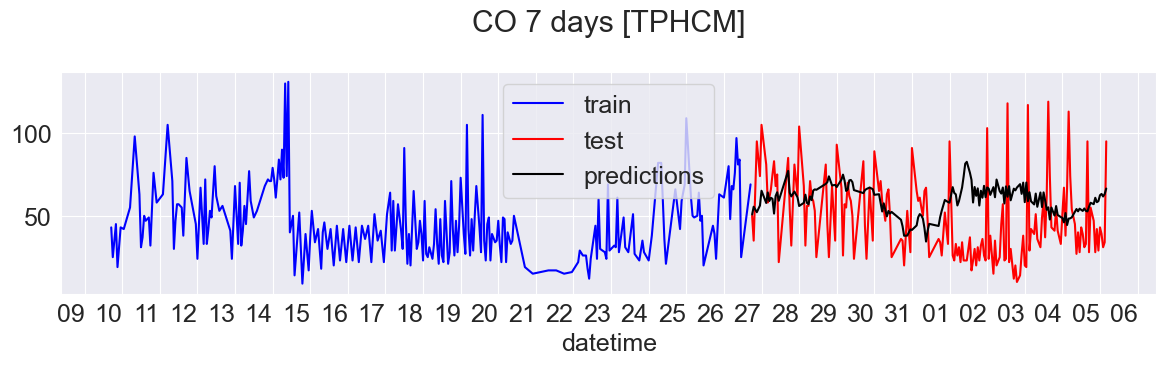

In [171]:
# Vẽ biểu đồ
plt.figure(figsize=(12,4))
train_co[-35*7:].plot(color='blue', label='train')
test_co.plot(color='red', label='test')
preds_xgb.plot(color='black', label='predictions')
plt.legend()
plt.title('CO 7 days [TPHCM]\n')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d')) 
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Mỗi ngày một điểm đánh dấu
plt.xticks(rotation=0)
# Thêm nhãn trục x là "datetime"
plt.xlabel('datetime')
plt.tight_layout()

In [172]:
# Evaluations
results_co_notune_nomet = evaluate_model_performance(
    y_true=test_co, 
    predictions=preds_xgb, 
    label='dt_co_no_tune_nomet')

results_co_notune_nomet

,dt_co_no_tune_nomet
MAE,24.195
MSE,849.242
RMSE,29.142
R-Squared,-0.467
MAPE,0.770
